In [1]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
if '..' not in sys.path:
    sys.path.insert(1,'..')

import numpy as np
import os
import pandas as pd
import ternary
import matplotlib.pyplot as plt
%matplotlib inline
from ternary.helpers import simplex_iterator
import pymatgen as mg


from helpers import fileload as fl

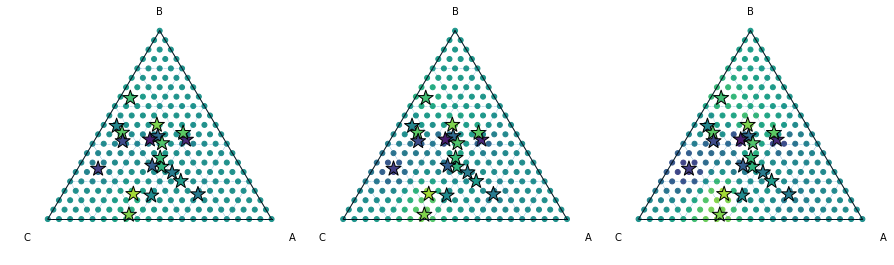

In [16]:
scale = 20
# points = [(scale,0,0),(0,scale,0),(0,0,scale),(scale/3,scale/3,scale/3),(scale/4,scale/4,scale/2),
#           (scale*2/3,scale/6,scale/6),(scale*0.8,scale*0.1,scale*0.1),(scale/2,scale/2,0)]
n = 20
points = np.random.rand(n,3)
points = points*scale/np.sum(points,axis=1)[:,None]
colors = np.random.rand(len(points))#[1,0.5,0,0.9,0.2,0.7,0.6,0.1]

fig, axes = plt.subplots(1,3,figsize=(15,4))
cmap=plt.cm.viridis
vmin = 0
vmax = 1

for i,ax in enumerate(axes):
    tax = ternary.TernaryAxesSubplot(ax=ax,scale=scale)
    
    tax.boundary(lw=1)
    tax.left_corner_label('C')
    tax.right_corner_label('A')
    tax.top_corner_label('B')
    tax.gridlines(multiple=scale/5)
    #tax.ticks(axis='lbr', linewidth=1,multiple=scale/5)
    ax.axis('off')

    interp_tuples = []
    interp_vals = []
    for tup in simplex_iterator(scale=scale):
        interp_tuples.append(tup)
        interp_vals.append(tuple_interp(points,colors,tup,wt_exp=i+1,norm_ord=i+1))
    tax.scatter(interp_tuples,c=interp_vals,s=25,cmap=cmap,colormap=cmap,vmin=vmin,vmax=vmax)
    
    tax.scatter(points,c=colors,s=250,cmap=cmap,colorbar=False,colormap=cmap,vmin=vmin,vmax=vmax,marker='*',
                linewidths=1.,edgecolors='k')

In [158]:
# def array_norm(array,axis=1,norm=2):
#     return np.sum(array**norm,axis=axis)**(1/norm)

def tuple_interp(tuples,vals,interp_tuple,wt_exp=2,norm_ord=2,max_wt=10):
    displacements = np.array([np.array(tup)-np.array(interp_tuple) for tup in tuples])
    norms = np.linalg.norm(displacements,axis=1,ord=norm_ord)
    weights = 1/norms**wt_exp
    #limit weights to max_wt
    weights[weights > max_wt] = max_wt
    interp_val = np.average(vals,weights=weights)
    return interp_val
    

In [95]:
tup

(1, 0, 0)

In [162]:
tuples = [(0,1,2),(2,3,4),(4,2,1)]
vals = [1,2,4]
interp_tuple = (0,1,2)
displacements = np.array([np.array(tup)-np.array(interp_tuple) for tup in tuples])
dists = np.linalg.norm(displacements,axis=1)
weights = 1/dists**2
weights[weights > 10] = 10
interp_val = np.average(vals,weights=weights)
interp_val, weights, dists

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


(1.0246575342465751,
 array([10.        ,  0.08333333,  0.05555556]),
 array([0.        , 3.46410162, 4.24264069]))

In [157]:
weights[weights>10] = 10
weights

array([10.        ,  0.08333333,  0.05555556])

In [133]:
tuple_interp(tuples,vals,interp_tuple,wt_exp=1,norm_ord=10)

1.8915426061909653

In [49]:
arr = np.array([[1,2,3],[2,3,4]])

In [51]:
np.linalg.norm(arr,axis=1)

array([3.74165739, 5.38516481])

In [4]:
#test with real data

tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/conductivity/plots')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':'dry'})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['Sigma_elec']>=0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_sigma'] = np.log10(data['Sigma_elec'])

In [6]:
from helpers.plotting import quat_slice_scatter, add_colorbar, rescale_ticks

0.85


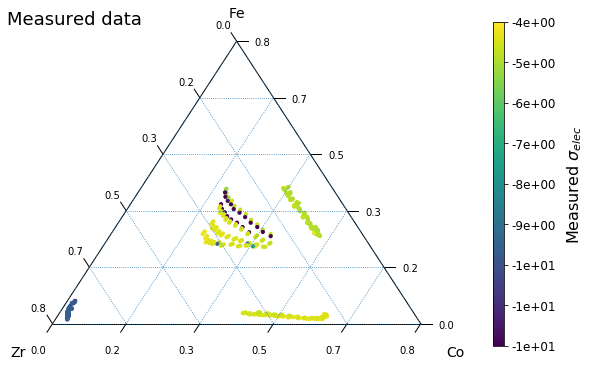

In [28]:
vmin = -12
vmax = -4
slice_start = 0.0
slice_width = 0.3

quat_slice_scatter(data,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis='Y',
                   tern_axes=['Co','Fe','Zr'],vmin=vmin,vmax=vmax,figsize=[7.5,6],
                   ptsize=10)

plt.title('Measured data',size=18,x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.0e')

0.85


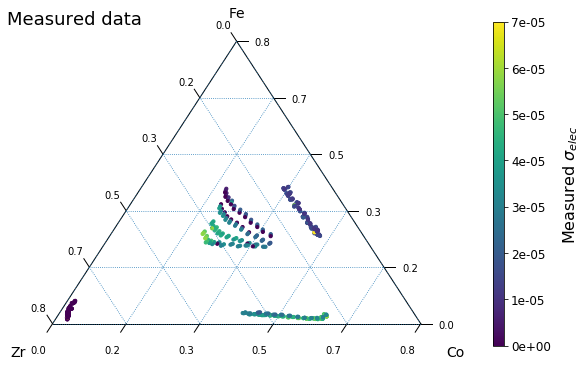

In [26]:
vmin = 0
vmax = 7e-5
slice_start = 0.0
slice_width = 0.3

quat_slice_scatter(data,z='Sigma_elec',slice_start=slice_start,slice_width=slice_width,slice_axis='Y',
                   tern_axes=['Co','Fe','Zr'],vmin=vmin,vmax=vmax,figsize=[7.5,6],
                   ptsize=10)

plt.title('Measured data',size=18,x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.0e')

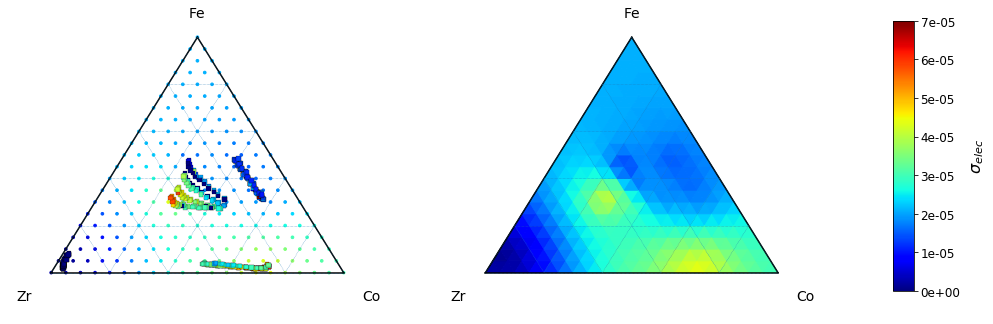

In [159]:
vmin = 0
vmax = 7e-5
z = 'Sigma_elec'
scale = 20
cmap = plt.cm.jet
labelsize = 14
add_labeloffset= 0

points = data.loc[:,['Co','Fe','Zr']].values
colors = data.loc[:,z].values

ptsum = np.sum(points,axis=1)[np.newaxis].T
scaled_pts = points*scale/ptsum

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
#left: scatter, right: heatmap
tax1 = ternary.TernaryAxesSubplot(scale=scale,ax=ax1)
tax2 = ternary.TernaryAxesSubplot(scale=scale,ax=ax2)

#plot interpolated values
interp_tuples = []
interp_vals = []
for tup in simplex_iterator(scale=scale):
    interp_tuples.append(tup)
    interp_vals.append(tuple_interp(scaled_pts,colors,tup,wt_exp=2,norm_ord=2))
d = dict(zip([t[0:2] for t in interp_tuples],interp_vals))

tax1.scatter(interp_tuples,c=interp_vals,s=7,cmap=cmap,colormap=cmap,vmin=vmin,vmax=vmax)
tax2.heatmap(d,cmap=cmap,vmin=vmin,vmax=vmax,colorbar=False)

#plot exp data
tax1.scatter(scaled_pts,cmap=cmap,s=20,marker='s',c=colors,vmin=vmin,vmax=vmax,edgecolors='k',linewidths=0.2)

for tax in [tax1,tax2]:
    tax.boundary()
    tax.ax.axis('off')
    tax.gridlines(multiple=scale/5)
    tax.right_corner_label('Co',fontsize=labelsize,offset=0.08+add_labeloffset)
    tax.top_corner_label('Fe',fontsize=labelsize,offset=0.2+add_labeloffset)
    tax.left_corner_label('Zr',fontsize=labelsize,offset=0.08+add_labeloffset)
    
add_colorbar(vmin=vmin,vmax=vmax,label='$\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.0e',cmap=cmap)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


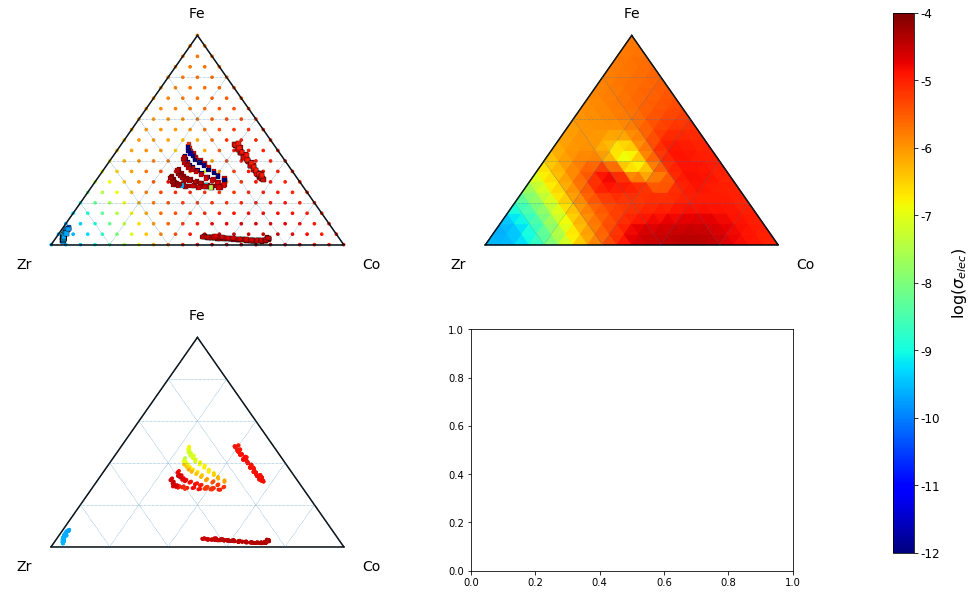

In [166]:
vmin = -12
vmax = -4
z = 'log_sigma'
scale = 20
cmap = plt.cm.jet
labelsize = 14
add_labeloffset= 0

points = data.loc[:,['Co','Fe','Zr']].values
colors = data.loc[:,z].values

ptsum = np.sum(points,axis=1)[np.newaxis].T
scaled_pts = points*scale/ptsum

fig, axes = plt.subplots(2,2,figsize=(14,10))
#left: scatter, right: heatmap
ax1 = axes[0,0] #exp scatter
ax2 = axes[0,1] #interp heatmap
ax3 = axes[1,0] #interp scatter
tax1 = ternary.TernaryAxesSubplot(scale=scale,ax=ax1)
tax2 = ternary.TernaryAxesSubplot(scale=scale,ax=ax2)
tax3 = ternary.TernaryAxesSubplot(scale=scale,ax=ax3)

#plot grid of interpolated values
interp_tuples = []
interp_vals = []
for tup in simplex_iterator(scale=scale):
    interp_tuples.append(tup)
    interp_vals.append(tuple_interp(scaled_pts,colors,tup,wt_exp=2,norm_ord=2))
d = dict(zip([t[0:2] for t in interp_tuples],interp_vals))

tax1.scatter(interp_tuples,c=interp_vals,s=7,cmap=cmap,colormap=cmap,vmin=vmin,vmax=vmax)
tax2.heatmap(d,cmap=cmap,vmin=vmin,vmax=vmax,colorbar=False)

#plot exp data
tax1.scatter(scaled_pts,cmap=cmap,s=20,marker='s',c=colors,vmin=vmin,vmax=vmax,edgecolors='k',linewidths=0.2)

for tax in [tax1,tax2,tax3]:
    tax.boundary()
    tax.ax.axis('off')
    tax.gridlines(multiple=scale/5)
    tax.right_corner_label('Co',fontsize=labelsize,offset=0.08+add_labeloffset)
    tax.top_corner_label('Fe',fontsize=labelsize,offset=0.2+add_labeloffset)
    tax.left_corner_label('Zr',fontsize=labelsize,offset=0.08+add_labeloffset)
    

#get interp values at exp coordinates
exp_interp_vals = []
for p in scaled_pts:
    exp_interp_vals.append(tuple_interp(scaled_pts,colors,p,wt_exp=2,norm_ord=2))
tax3.scatter(scaled_pts,c=exp_interp_vals,cmap=cmap,vmin=vmin,vmax=vmax,s=8)
             
             
add_colorbar(vmin=vmin,vmax=vmax,label='log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.0f',cmap=cmap)

In [150]:
p

array([14.54859372,  0.64372422,  4.80768206])

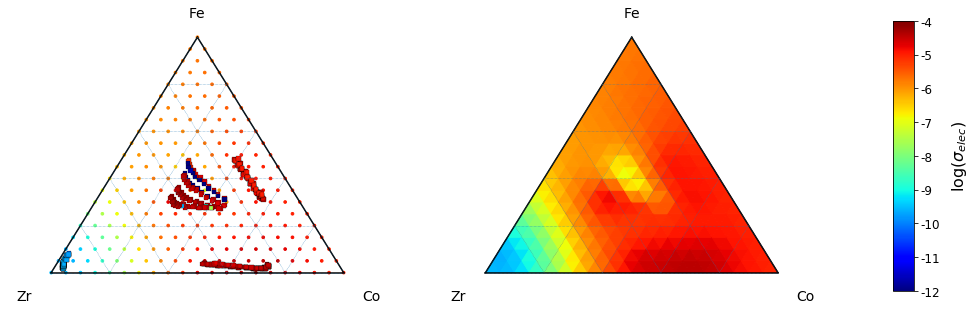

In [160]:
vmin = -12
vmax = -4
z = 'log_sigma'
scale = 20
cmap = plt.cm.jet
labelsize = 14
add_labeloffset= 0

points = data.loc[:,['Co','Fe','Zr']].values
colors = data.loc[:,z].values

ptsum = np.sum(points,axis=1)[np.newaxis].T
scaled_pts = points*scale/ptsum

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
#left: scatter, right: heatmap
tax1 = ternary.TernaryAxesSubplot(scale=scale,ax=ax1)
tax2 = ternary.TernaryAxesSubplot(scale=scale,ax=ax2)

#plot interpolated values
interp_tuples = []
interp_vals = []
for tup in simplex_iterator(scale=scale):
    interp_tuples.append(tup)
    interp_vals.append(tuple_interp(scaled_pts,colors,tup,wt_exp=2,norm_ord=2))
d = dict(zip([t[0:2] for t in interp_tuples],interp_vals))

tax1.scatter(interp_tuples,c=interp_vals,s=7,cmap=cmap,colormap=cmap,vmin=vmin,vmax=vmax)
tax2.heatmap(d,cmap=cmap,vmin=vmin,vmax=vmax,colorbar=False)

#plot exp data
tax1.scatter(scaled_pts,cmap=cmap,s=20,marker='s',c=colors,vmin=vmin,vmax=vmax,edgecolors='k',linewidths=0.2)

for tax in [tax1,tax2]:
    tax.boundary()
    tax.ax.axis('off')
    tax.gridlines(multiple=scale/5)
    tax.right_corner_label('Co',fontsize=labelsize,offset=0.08+add_labeloffset)
    tax.top_corner_label('Fe',fontsize=labelsize,offset=0.2+add_labeloffset)
    tax.left_corner_label('Zr',fontsize=labelsize,offset=0.08+add_labeloffset)
    
add_colorbar(vmin=vmin,vmax=vmax,label='log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.0f',cmap=cmap)

In [139]:
iv1 = interp_vals

In [140]:
iv1,iv2

([-8.675755688852265,
  -9.128217150390462,
  -8.689452835559521,
  -8.011472107098625,
  -7.52608033201147,
  -7.141734094819555,
  -6.834163517754874,
  -6.618415867488042,
  -6.465240672549834,
  -6.343347745843473,
  -6.24459390493504,
  -6.163912792126874,
  -6.10718338369885,
  -6.081359213958223,
  -6.06237431116881,
  -6.029230973150604,
  -6.001772904744521,
  -5.97608577028966,
  -5.97173301250925,
  -5.984321811345685,
  -5.995284855765351,
  -9.004163877996,
  -8.888853561703323,
  -8.23214633918101,
  -7.673075174541962,
  -7.243406228281554,
  -6.896280707903345,
  -6.61651700640514,
  -6.429242041057427,
  -6.303295213245787,
  -6.202516357906027,
  -6.119070956512373,
  -6.065785744919237,
  -6.04756068064677,
  -6.0328213391815,
  -5.996328882322496,
  -5.966623636084185,
  -5.939362872381895,
  -5.936165174756544,
  -5.95154450100943,
  -5.964875287808061,
  -8.368562141352626,
  -8.132345130856097,
  -7.630227353028381,
  -7.201043422824504,
  -6.85692610650071,
  -6